# Advanced Machine Learning
## Project 1: Bayesian Networks
----------------
FCUL - MSc. Data Science - November 2024\
Year 1, semester 1
- Duarte Valente - fc64335
- METE AS TUAS CENAS
----------------
faculty: Helena Aidos

## Abstract

One of the leading causes of death in Europe is **cardiovascular disease** (CVD), with strongly associated risk factors such as age, sex, lack of physical activity, smoking habits and high body mass index. Other understated risk factors have also been associated such as depression, socieconomic status and sleep [1]. Accurate CVD risk prediction is essential to improve public health by identifying high risk patients and behaviors.   

In this report, we will be using a limited health dataset, by drawing upon its structure and probability distribution. The goal is to construct a **Bayesian Network** by identifying the relationships between nodes, where each node represents a cardiovascular risk factor, based on the dataset's underlying patterns, analyzing the relationships between variables and to successfully classify 3 medical conditions: **diabetes**, **hypercholesterolemia** and **hypertension**.

## Dataset and Network definition

Generally, we can expect that the age and sex will not be influenced by the remaining risk factors.

Based on these assumptions, we can now define the nodes in our Bayesian network as:

The data was collected in Spain between 2012-2016 from annual health assessments of adult workers covered by a private insurance provider, along with additional census information. The variables present in our dataset are:

**Age** - Ranging from 24 to 74, and grouped in age brackets as: less than 24, from 24 to 34, from 34 to 44, from 44 to 54, from 54 to 64, from 64 and 74

**Anxiety** - Classified as either "Yes" or "No"

**Body Mass Index** - Following the WHO guidelines and grouping patients as: underweight (<18.5 kg/m2), normal weight (18.5-25 kg/m2), overweight (25-30 kg/m2), and obese (≥ 30 kg/m2)

**Depression** - Classified as either "Yes" or "No"

**Diabetes** - Defined as a patient medicated or with glycaemia ≥125mg/dL

**Education Level** - Where a larger index indicates a higher education

**Hypercholesterolemia** - Defined as a patient medicated or with total cholesterol ≥240mg/dL

**Hypertension** - Defined as a patient medicated or with systolic/diastolic blood pressure ≥140/90mm Hg

**Physical Activity** - Classified as insufficiently active or regularly active

**Sex** - Categorized as male or female

**Sleep Duration** - Classified as: less than 6 hours, between 6-9 hours, or longer than 9 hours

**Smoker Profile** - Classified as non-smoker, ex-smoker or smoker

**Socioeconomic Status** - Where a larger index indicates a higher socioeconomic level






The data had already been preprocessed and all outliers, duplicates, and missing values had been previously discarded.

## 1. Exploratory Data Analysis

### 1.1.  Loading the data

In the following cell you can find the libraries imported for use in this project:

- `pandas`: For data manipulation;
- `pgmpy`: Allows the implementation of structure learning, parameter estimation, and inference for probabilistic graphical models;
- `imblearn`: To assist in managing imbalanced datasets and allowing the use of SMOTE - Synthetic Minority Over-sampling Technique;
- `matplotlib` and `seaborn`: Enable data visualization to explore relationships and patterns in the dataset effectively;
- `random`: To generate random values and assisting in generating synthetic samples;
- `math`: To assist in calculations for data visualization,
- `warnings`: To suppress warnings, in particular compatibility and memory warnings, and display cleaner outputs.


In [1]:
# generic libs
import pandas as pd
import numpy as np
import random
import math

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing and Sampling
from pandas.api.types import CategoricalDtype
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

# Structure Learning
from pgmpy.base import DAG
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
import networkx as nx

# Parameter Learning
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD

# Model Evaluation and Inference
from pgmpy.inference import VariableElimination
from sklearn.metrics import classification_report, confusion_matrix

# Presentation and warning supression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pgmpy")
warnings.simplefilter("ignore", category=FutureWarning)


In the following cell, we will be loading the training dataset (“cardiovascular_train.csv”) and the test set (“cardiovascular_test.csv”) and displaying the first few rows of the DataFrame for an initial inspection. We have also confirmed that there are no missing values in either datasets. 

In [2]:
df_train = pd.read_csv('./Data/cardiovascular_train.csv')
df_test = pd.read_csv('./Data/cardiovascular_test.csv')

df_train.head()

,Age,Anxiety,BodyMassIndex,Depression,Diabetes,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus
0,54-64,No,Overweight,No,No,2,No,No,Regularly Active,Male,6-9hours,Smoker,3
1,24-34,No,Obese,No,No,3,Yes,No,Regularly Active,Female,6-9hours,Non_Smoker,3
2,24-34,No,Overweight,No,No,2,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1
3,34-44,No,Overweight,No,No,2,Yes,Yes,Regularly Active,Male,<6hours,Non_Smoker,3
4,44-54,No,Overweight,No,Yes,2,No,Yes,Regularly Active,Female,6-9hours,Smoker,3


In [3]:
print(f"""
Null Values for Train Split:
{df_train.isnull().sum()}

Null Values for Test Split:
{df_train.isnull().sum()}
""")


Null Values for Train Split:
Age                     0
Anxiety                 0
BodyMassIndex           0
Depression              0
Diabetes                0
EducationLevel          0
Hypercholesterolemia    0
Hypertension            0
PhysicalActivity        0
Sex                     0
SleepDuration           0
SmokerProfile           0
SocioeconomicStatus     0
dtype: int64

Null Values for Test Split:
Age                     0
Anxiety                 0
BodyMassIndex           0
Depression              0
Diabetes                0
EducationLevel          0
Hypercholesterolemia    0
Hypertension            0
PhysicalActivity        0
Sex                     0
SleepDuration           0
SmokerProfile           0
SocioeconomicStatus     0
dtype: int64



### 1.2 Data Visualization and Processing

In order to better understand class (im)balance and to gauge how representative our dataset is, we will be introducing a column **is_healthy**. This binary ("True" or "False") column will inform the distribution of unhealthy (e.g. a patient exhibiting hypercholesterolemia, hypertension or diabetes) to healthy individuals (e.g. absence of hypercholesterolemia, hypertension and diabetes). The goal is to balance the data using random undersampling on healthy patients, a process that will be explored in detail later.

We are aware that this new column could introduce overly broad information in our model and combine distinct medical conditions into a single metric. For example, while smoking increases the likelihood of being unhealthy, it does not directly indicate which specific disease is caused. Therefore, in order to set up our model to learn precise association between risk factors and medical conditions, we have chosen to not include this metric while training the model.

In [ ]:
# Creating metric: is_healthy [True/False] 
# This metric should not be used to train the model as it would polute our connections and remove specifity in our data

diseases_cols = ['Diabetes', 'Hypercholesterolemia', 'Hypertension']

def get_isHealthy(patient):
    return not any(patient[disease] == 'Yes' for disease in diseases_cols)

df_train['is_healthy'] = df_train.apply(get_isHealthy, axis=1)

In the following cells, we confirmed that our column had been successfully inserted and that the order from our ordinal data (e.g age, body mass index, sleep duration and smoker profile) is preserved. These variables can be considered to have an inherent order and hierarchy, which will enable a clearer data visualization. In order to visualize the data, we also need to identify the frequency of values in each category within each variable in the training dataset.  

In [5]:
df_train.head()

,Age,Anxiety,BodyMassIndex,Depression,Diabetes,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus,is_healthy
0,54-64,No,Overweight,No,No,2,No,No,Regularly Active,Male,6-9hours,Smoker,3,True
1,24-34,No,Obese,No,No,3,Yes,No,Regularly Active,Female,6-9hours,Non_Smoker,3,False
2,24-34,No,Overweight,No,No,2,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1,True
3,34-44,No,Overweight,No,No,2,Yes,Yes,Regularly Active,Male,<6hours,Non_Smoker,3,False
4,44-54,No,Overweight,No,Yes,2,No,Yes,Regularly Active,Female,6-9hours,Smoker,3,False


In [6]:
# defining and distinguishing the ordinal from nominal data

age_dtype = CategoricalDtype(categories=['18-24', '24-34', '34-44', '44-54', '54-64', '64-74'], ordered=True)
bmi_dtype = CategoricalDtype(categories=['Underweight', 'Normal', 'Overweight', 'Obese'], ordered=True)
sleep_dtype = CategoricalDtype(categories=['<6hours', '6-9hours', '>9hours'], ordered=True)
smoker_dtype = CategoricalDtype(categories=['Non_Smoker', 'Ex_Smoker', 'Smoker'], ordered=True)

df_train['Age'] = df_train['Age'].astype(age_dtype)
df_train['BodyMassIndex'] = df_train['BodyMassIndex'].astype(bmi_dtype)
df_train['SleepDuration'] = df_train['SleepDuration'].astype(sleep_dtype)
df_train['SmokerProfile'] = df_train['SmokerProfile'].astype(smoker_dtype)

In [7]:
# getting train value counts
for col in df_train.columns:
    print(df_train[col].value_counts(),'\n')

Age
34-44    1411
44-54    1148
24-34     655
54-64     594
18-24      28
64-74       9
Name: count, dtype: int64 

Anxiety
No     3454
Yes     391
Name: count, dtype: int64 

BodyMassIndex
Overweight     1440
Normal         1344
Obese           968
Underweight      93
Name: count, dtype: int64 

Depression
No     3824
Yes      21
Name: count, dtype: int64 

Diabetes
No     3669
Yes     176
Name: count, dtype: int64 

EducationLevel
2    2914
3     926
1       5
Name: count, dtype: int64 

Hypercholesterolemia
No     2351
Yes    1494
Name: count, dtype: int64 

Hypertension
No     3107
Yes     738
Name: count, dtype: int64 

PhysicalActivity
Insufficiently Active    2770
Regularly Active         1075
Name: count, dtype: int64 

Sex
Male      2618
Female    1227
Name: count, dtype: int64 

SleepDuration
6-9hours    3440
<6hours      401
>9hours        4
Name: count, dtype: int64 

SmokerProfile
Non_Smoker    2175
Smoker        1038
Ex_Smoker      632
Name: count, dtype: int64 

Socioeco

In order to visualize the data more clearly, we will be presenting two sets of barplots containing non-binary data and binary data, respectively. 

#### 1.2.1 Non-Binary Data Visualization

From our data visualization it follows that the variables Age, BMI, EducationLeavel, SleepDuration follow a normal distribution. 

The datatset features predominatly individuals with age 34-54, who are normal or overweight, with medium education (presumably high school), who sleep 6-9 hours and do not smoke. 

The SocioeconomicStatus of our sample is predominantly higher, and we found its distribution surprising since, as a country with income inequality, Spain has with a larger percentage of the population in lower-income or middle-income brackets and a smaller proportion in the wealthier brackets.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


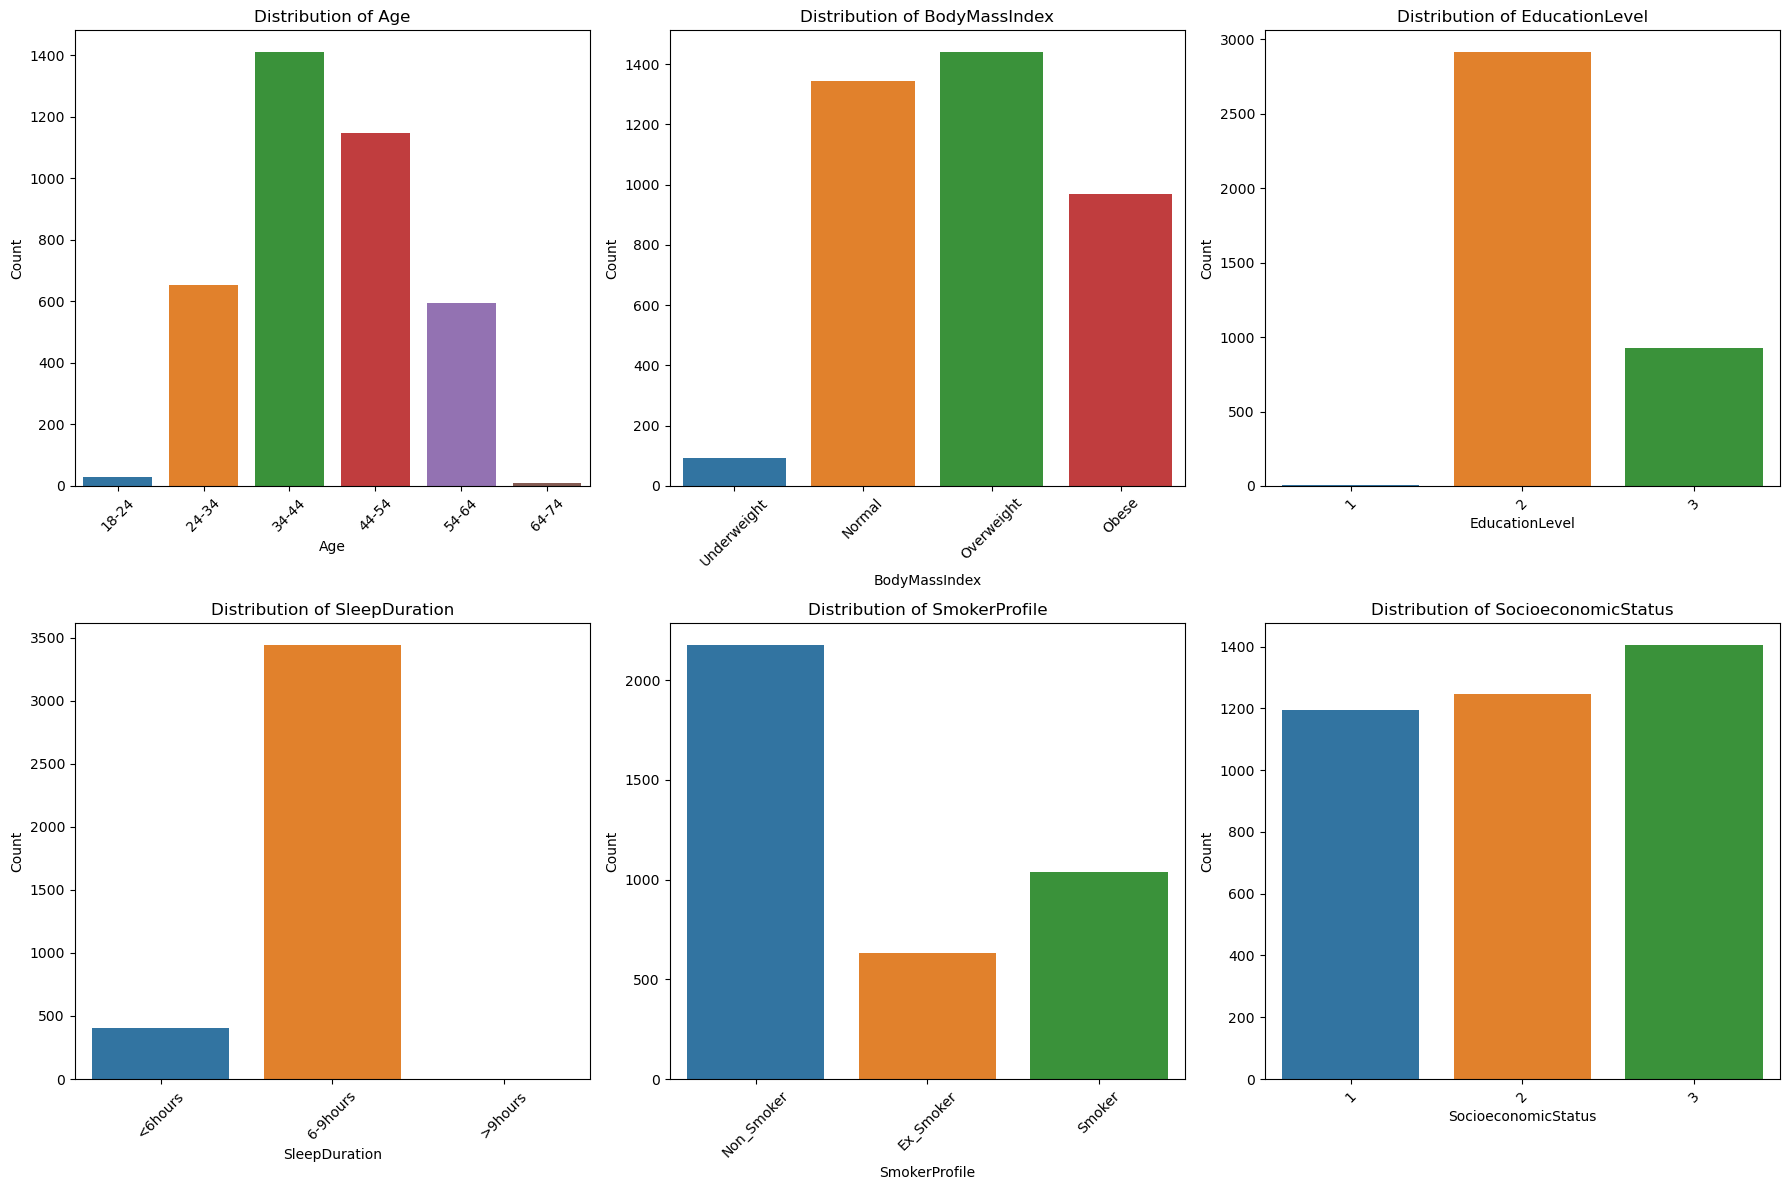

In [ ]:
# Visualizing Distributions on Non-Binary Data pre-SMOTE

multi_cols = ['Age', 'BodyMassIndex', 'EducationLevel', 'SleepDuration', 'SmokerProfile', 'SocioeconomicStatus']

num_cols = len(multi_cols)
cols_per_row = 3  # Number of plots per row
num_rows = math.ceil(num_cols / cols_per_row)  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(18, 6 * num_rows))  # Adjust size as needed
axes = axes.flatten()  # Flatten axes for easier indexing

for idx, col in enumerate(multi_cols):
    sns.countplot(x=col, hue=col, data=df_train, palette="tab10", ax=axes[idx], legend=False)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

#### 1.2.2 Binary Data Visualization

From our data visualization it follows that the our binary variables (e.g. Anxiety, Depression, Diabetes, Hypercholesterolemia, Hypertension, PhysicalActivity, Sex and is_healthy) show a clear imbalance, with the majority class having many more instances that the minority class. Most variables would still provide valuable information, even if they are imbalanced. Given the extremely small minority class present in the case of depression and diabetes, we can expect challenges in training the model, since the minority class will not have enough examples to produce robust predictions.

The dataset shows predominantly individuals that do not showcase anxiety, depression, diabetes, hypertension and are insufficiently active. There is also an imbalance between the frequency of males and females. However, is_healthy reveals that the frequency of healthy to unhealthy individuals is well balanced. This indicates that while each medical condition is less common on their own, the existence of comorbidities in the dataset creates a balance, approximating the number of unhealthy individuals to the number of healthy individuals.

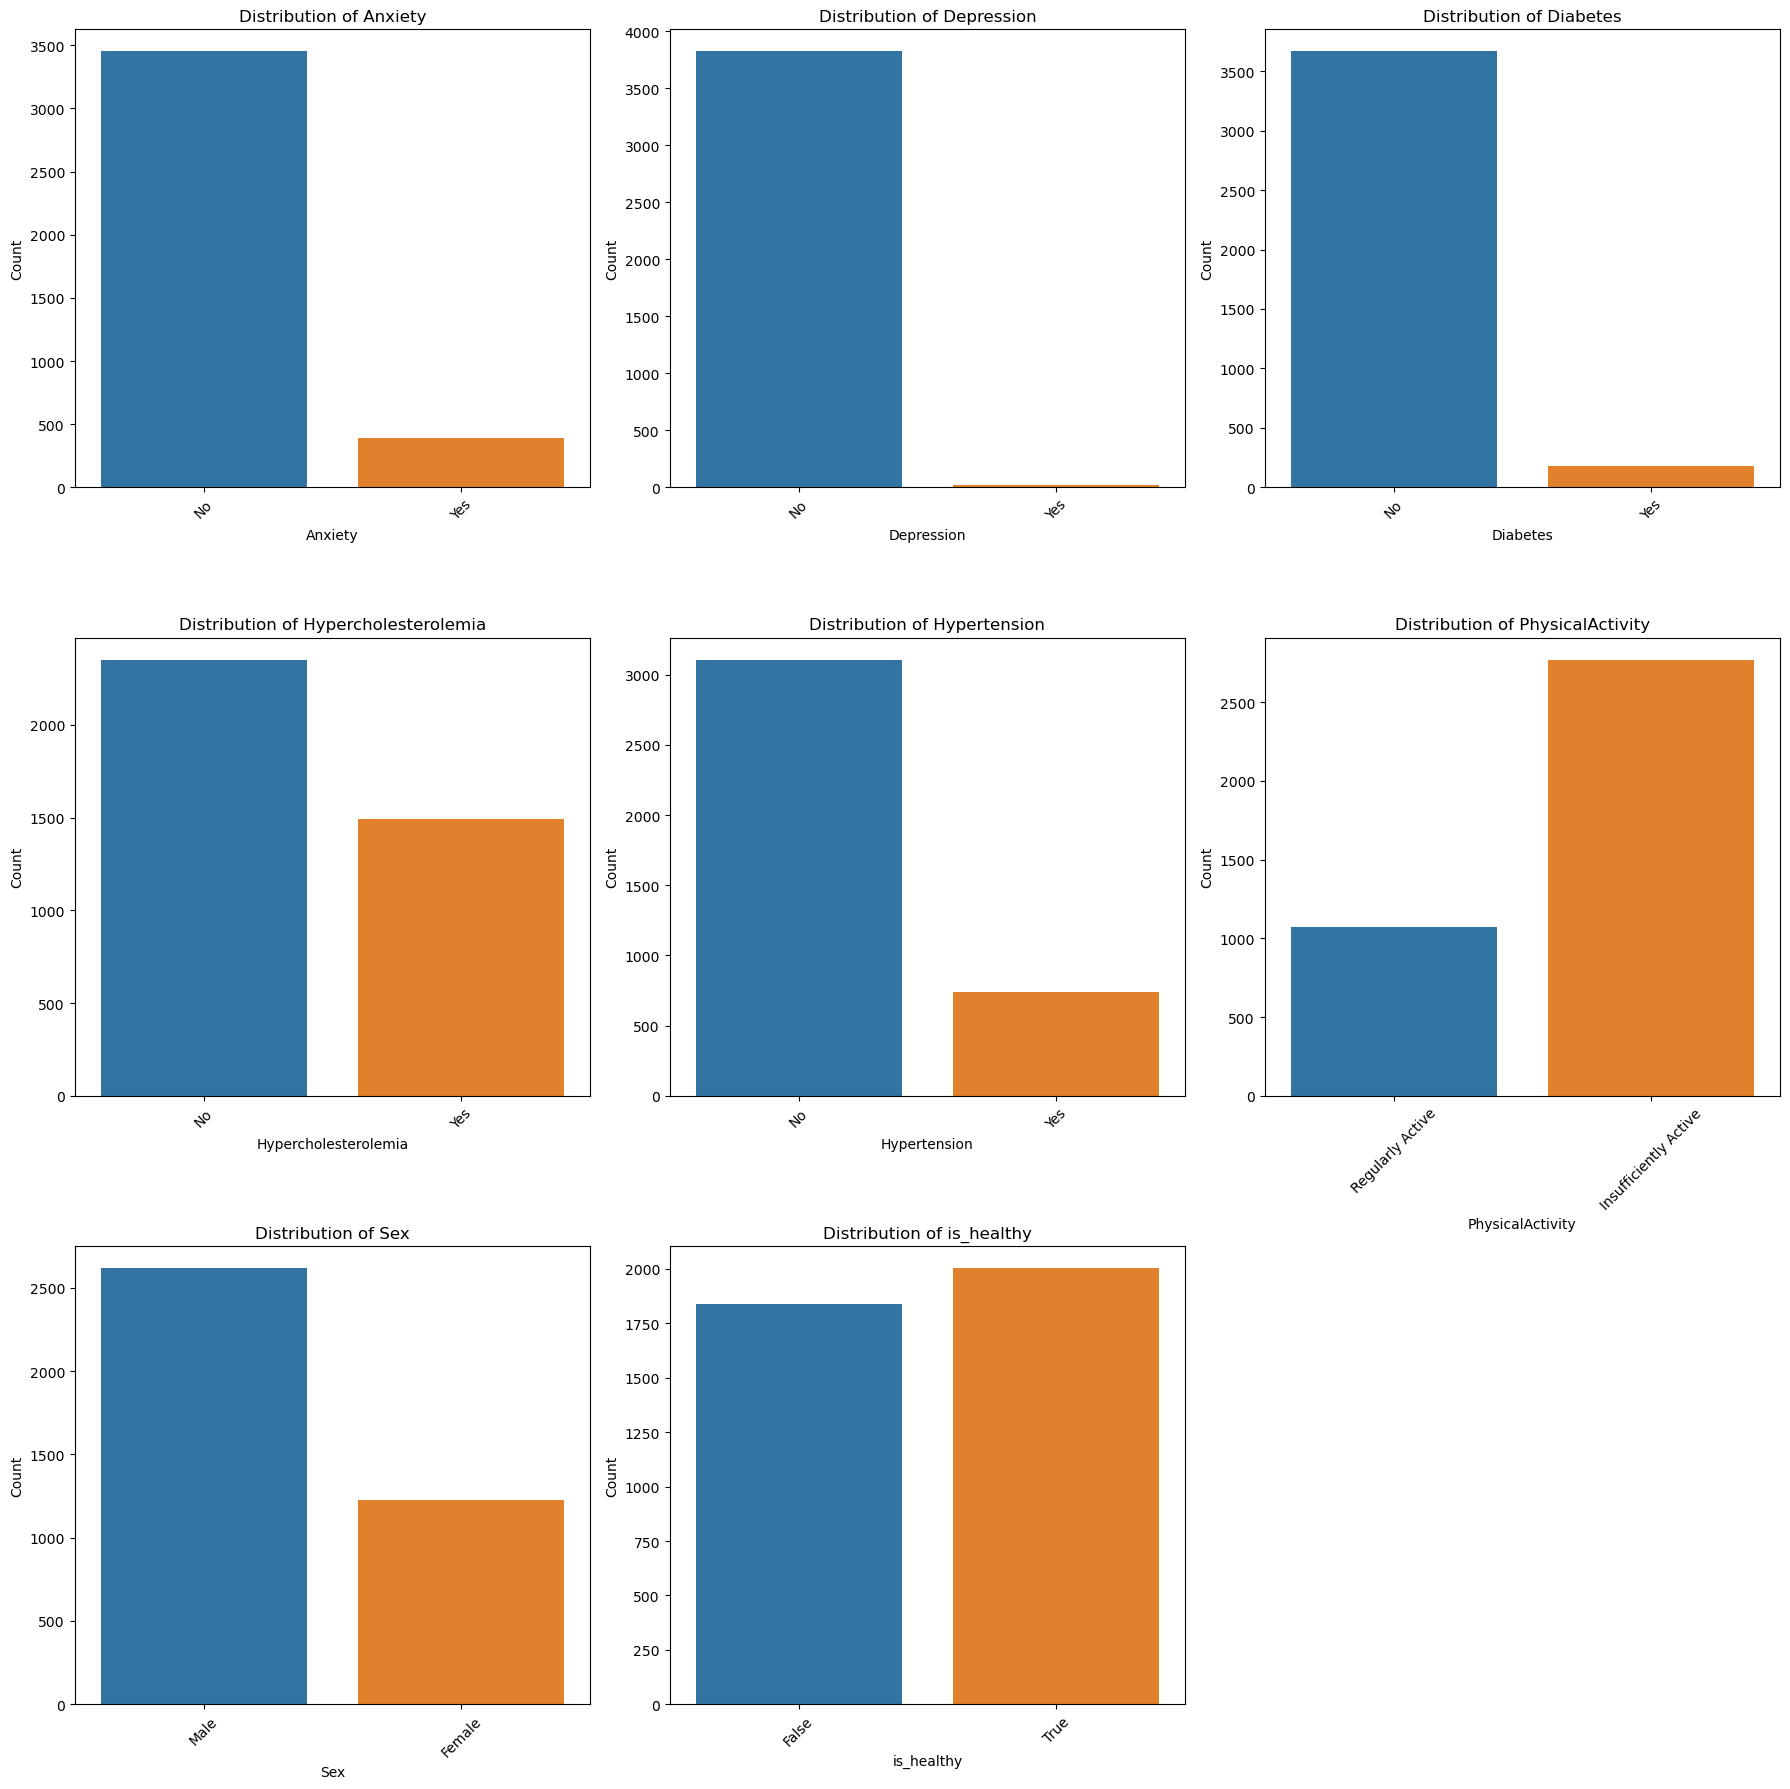

In [10]:
# Visualizing Distributions on Binary Data Pre-SMOTE

binary_cols = ['Anxiety','Depression', 'Diabetes', 'Hypercholesterolemia', 'Hypertension', 'PhysicalActivity', 'Sex', 'is_healthy']

num_cols = len(binary_cols)
cols_per_row = 3  # Number of plots per row
num_rows = math.ceil(num_cols / cols_per_row)  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(18, 6 * num_rows))  # Adjust size as needed
axes = axes.flatten()  # Flatten axes for easier indexing

for idx, col in enumerate(binary_cols):
    sns.countplot(x=col, hue=col, data=df_train, palette="tab10", ax=axes[idx], legend=False)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplots if the number of columns is not a multiple of 3
for idx in range(num_cols, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Our attempt to use undersamling on Healthy patients will not be applied as is_healthy is well balanced.

df_train = df_train.drop(columns='is_healthy')

#### Applying SMOTE to Diabetes Column

In [ ]:
categorical_columns = ['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes', # SMOTENC Needs at least one column to be marked as numeric.
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',                    # the column marked as numeric was SocioeconomicStatus. (This did not affect Socioeconomic Status)
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile']                 

In [13]:
# define Train/Test Splits

X_train = df_train.drop('Diabetes', axis=1)
y_train = df_train['Diabetes']
X_test = df_test.drop('Diabetes', axis=1)
y_test = df_test['Diabetes']

In [14]:
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_columns if col != 'Diabetes']

# apply SMOTE to create Diabetes = Yes samples
smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy=0.2)

X_train_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)
df_resampled = X_train_resampled
df_resampled['Diabetes'] = y_resampled

In [15]:
# Here we can see that the smote has indeed worked, by oversampling the Diabetes to a scale 2:10 we go from 176 Diabetes YES sampled to 733
print(y_train.value_counts())
print(y_resampled.value_counts())

Diabetes
No     3669
Yes     176
Name: count, dtype: int64
Diabetes
No     3669
Yes     733
Name: count, dtype: int64


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


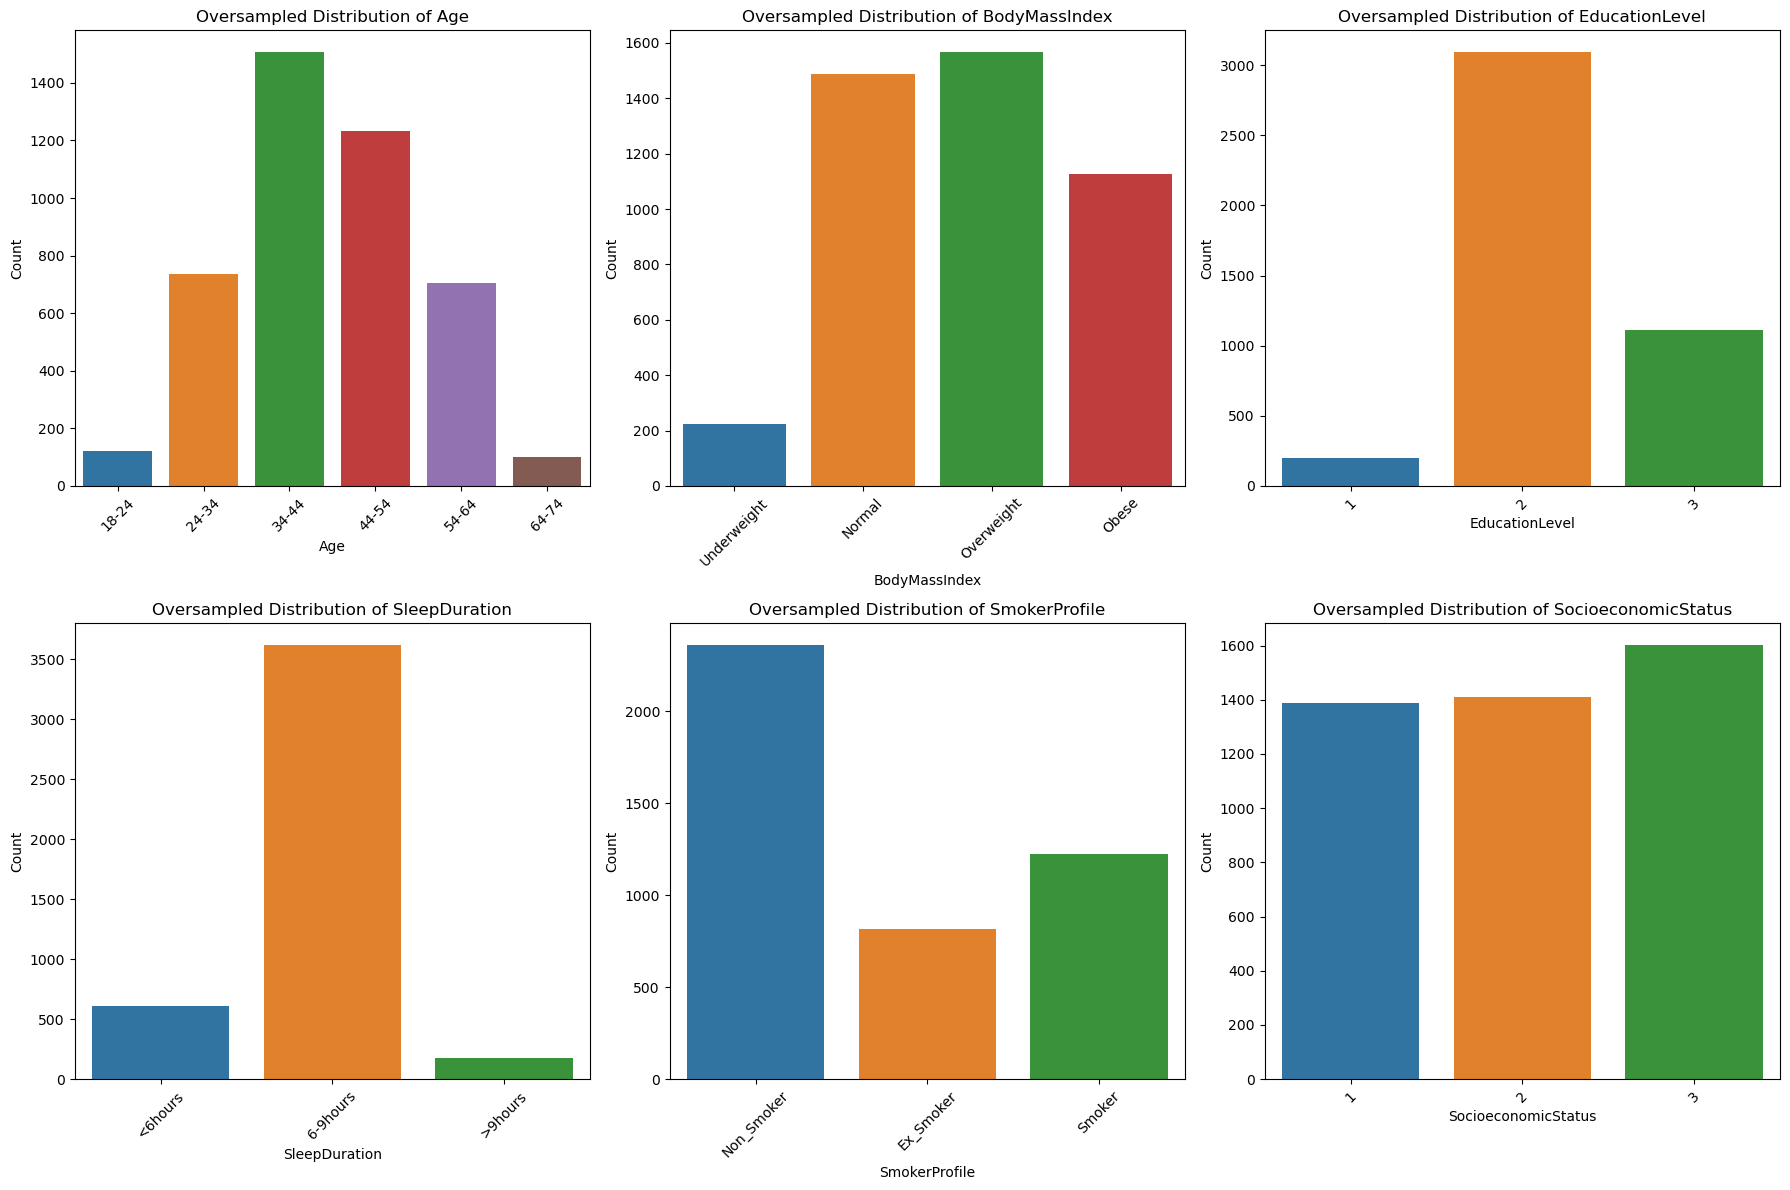

In [16]:
# Visualizing Distributions on Non-Binary Data Pos-SMOTE
num_cols = len(multi_cols)
cols_per_row = 3  # Number of plots per row
num_rows = math.ceil(num_cols / cols_per_row)  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(18, 6 * num_rows))  # Adjust size as needed
axes = axes.flatten()  # Flatten axes for easier indexing

for idx, col in enumerate(multi_cols):
    sns.countplot(x=col, hue=col, data=df_resampled, palette="tab10", ax=axes[idx], legend=False)
    axes[idx].set_title(f'Oversampled Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplots if the number of columns is not a multiple of 3
for idx in range(num_cols, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
# The most interesting changes given after the oversampling on diabetes is that some other classes there were almost non-existent have a larger sample size to the point of being clearly visible in the plots in way they weren't previously
# Age (OLD), EducationLevel(1) & SleepDuration(>9hours)

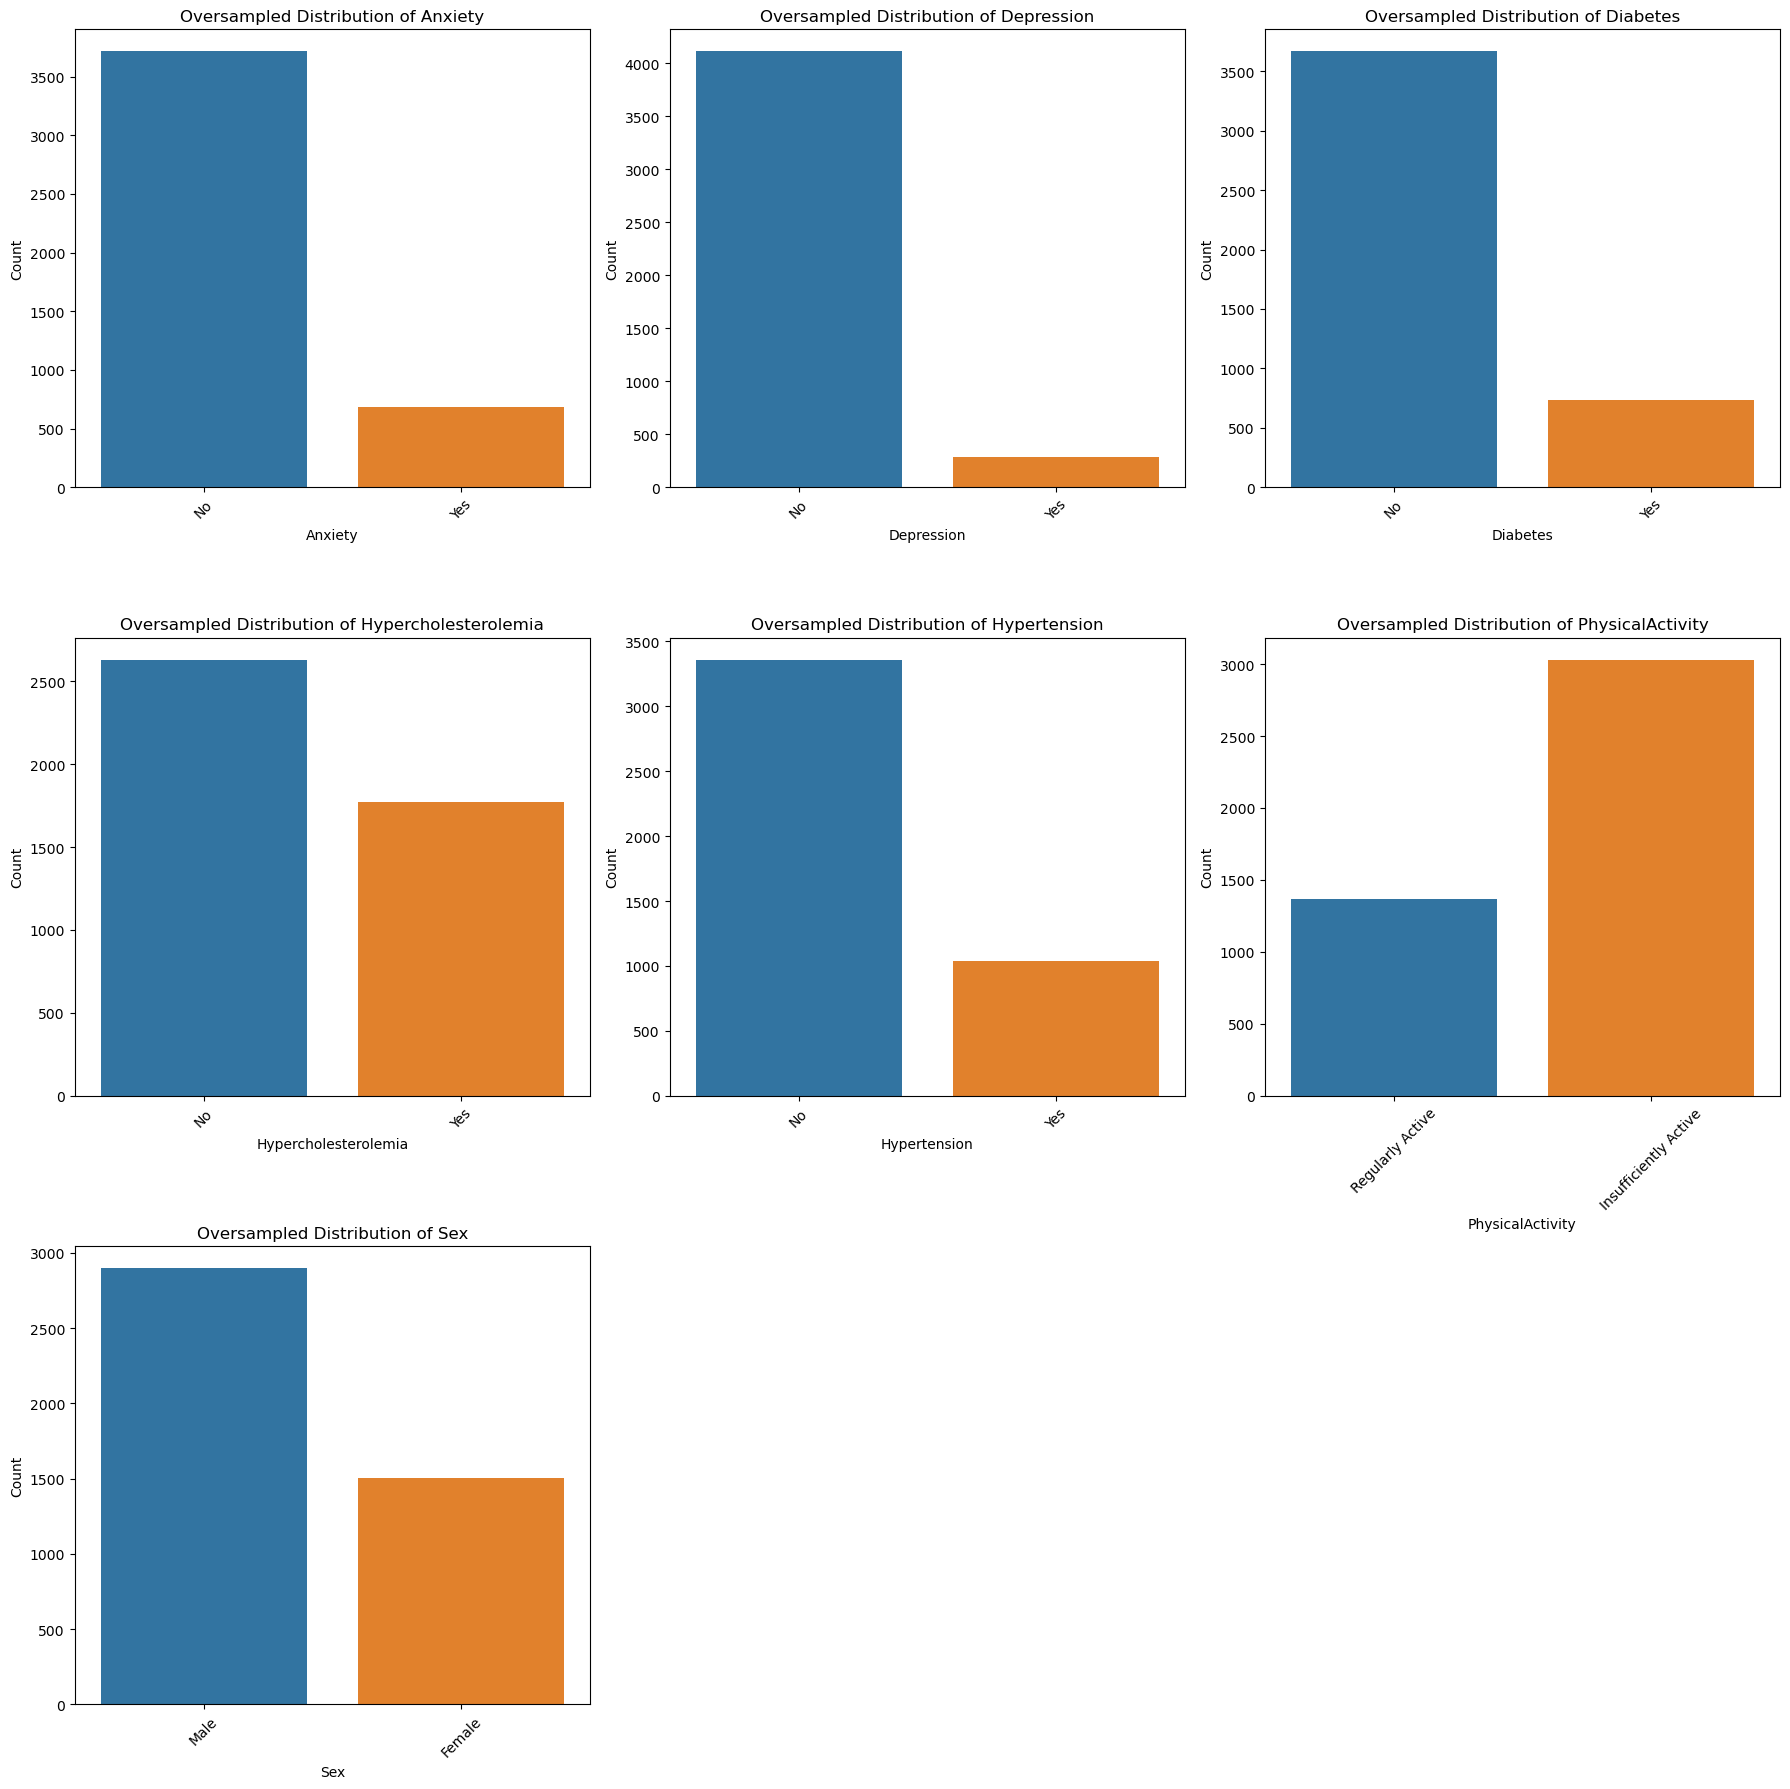

In [18]:
# Visualizing Distributions on Binary Data Pos-SMOTE

binary_cols = ['Anxiety','Depression', 'Diabetes', 'Hypercholesterolemia', 'Hypertension', 'PhysicalActivity', 'Sex']

num_cols = len(binary_cols)
cols_per_row = 3  # Number of plots per row
num_rows = math.ceil(num_cols / cols_per_row)  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(18, 6 * num_rows))  # Adjust size as needed
axes = axes.flatten()  # Flatten axes for easier indexing

for idx, col in enumerate(binary_cols):
    sns.countplot(x=col, hue=col, data=df_resampled, palette="tab10", ax=axes[idx], legend=False)
    axes[idx].set_title(f'Oversampled Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplots if the number of columns is not a multiple of 3
for idx in range(num_cols, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Once again we have an overall more balanced distribution of all characteristics. Special Note of Diabetes (The target of the balance in the first place) and Anxiety. The other diseases have also gone up but I don't think it is that significant

## 2. Bayesian Network

#### 2.1. Structure Learning - Creating a DAG 

In order to reduce the edges that did not make sense, we have opted by adding the variables "Age" and "Sex" into a blacklist, so that the model identifies these nodes as root nodes, since age and sex influence other variables but are not influenced themselves.

In [20]:
nodes = set(df_train.columns)

# Claiming that nothing can influence the Age or Sex but that these can influence other nodes.
root_nodes = ['Age', 'Sex']
impossible_connections = []

for root_node in root_nodes:
    for node in nodes:
        connection = (node, root_node)
        impossible_connections.append(connection)

blacklist = set(impossible_connections)

The next cell will initialize a DAG (Directed Acyclic Graph) with the given nodes. The graph starts with random connections between the nodes, apart from the root nodes defined in the blacklist. Using a mapping dictionary, we will map the node indices to their original labels.

In [21]:
def initialize_graph(nodes, p=1, blacklist=[]):
    G = DAG()
    G.add_nodes_from(nodes=nodes)
    init = G.get_random(n_nodes=len(nodes), edge_prob=p)
    ls = []
    mapping = {k: nodes[k] for k in range(len(nodes))}
    for i, j in init.edges:
        edge = (mapping[i], mapping[j])
        if edge not in blacklist:
            ls.append(edge)
    G.add_edges_from(ebunch=ls)
    return G

After initializing our DAG, we will be applying the Hill-Climbing algorithm that will iteratively change the created edges by adding, removing and reversing them. This choice leverages our domain knowledge of the problem, and it is a good choice for smaller datasets. 

We have excluded Exhaustive Search algorithm since our prior knowledge makes it unnecessary to iterate over all possible network structures and Hill-Climbing is an exelent alternative that gets the local maxima instead of the total maxima. The PC algorithm is also not ideal since our dataset is not extensive and we want to incorporate prior knowledge.

Regarding the scoring function, we will be using BDeu since we do not have an large amount of cathegorical data and we consider that the use of our domain knowledge on this problem is more important than the data fit of, what we consider to be, a small dataset. In order to introduce an element of randomness, we have set the probabilities for edge creation between 30-70%, so that the model could explore a variety of starting structures for the Bayesian network. After consecutive iterations (in our case, iteration stops explicitly after 15 attempts), the model will choose the best highest BDeu score and select the corresponding model.

In [ ]:
# Setting Score Metric as DBeu 
score_metric = BDeuScore(df_train)
es = HillClimbSearch(df_train)

In [ ]:
# Creating a random start structure of the DAG with a random factor floating between 30 and 70% randomness.

rand_list = [random.randrange(3, 7) for _ in range(0,15)]
rand_list = [x/10 for x in rand_list]
best_eval = 0

# estimating the best structure for our data using hill-climbing technique. To work around its random nature we are letting it run 15 times and picking the one the best score acording to BDeu.
for x, y in zip(range(0,15), rand_list):
    current_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=y, blacklist=blacklist))
    curr_eval = score_metric.score(current_model)
    print(curr_eval)
    if curr_eval < best_eval:
        best_eval = curr_eval
        best_model = current_model

print(best_eval)

  0%|          | 0/1000000 [00:00<?, ?it/s]

-31548.932198864135


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31578.79452624167


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31596.38800699599


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31546.491486536615


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31546.49148653662


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31926.828063859906


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31546.491486536608


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31614.964231086873


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31548.188077512194


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31548.932198864146


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31578.794526241665


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31527.10305504308


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31563.253482721295


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31546.133087120605


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31691.6479164245
-31926.828063859906


[('SmokerProfile', 'Hypercholesterolemia'), ('SmokerProfile', 'BodyMassIndex'), ('Depression', 'EducationLevel'), ('Diabetes', 'Hypertension'), ('Diabetes', 'PhysicalActivity'), ('SleepDuration', 'Depression'), ('Hypercholesterolemia', 'Hypertension'), ('Hypercholesterolemia', 'SleepDuration'), ('Age', 'PhysicalActivity'), ('Age', 'SmokerProfile'), ('Age', 'Hypercholesterolemia'), ('Age', 'SocioeconomicStatus'), ('Age', 'SleepDuration'), ('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'BodyMassIndex'), ('PhysicalActivity', 'SmokerProfile'), ('PhysicalActivity', 'EducationLevel'), ('Hypertension', 'BodyMassIndex'), ('Hypertension', 'Anxiety'), ('BodyMassIndex', 'SocioeconomicStatus'), ('Sex', 'PhysicalActivity'), ('Sex', 'Anxiety'), ('EducationLevel', 'SocioeconomicStatus')]


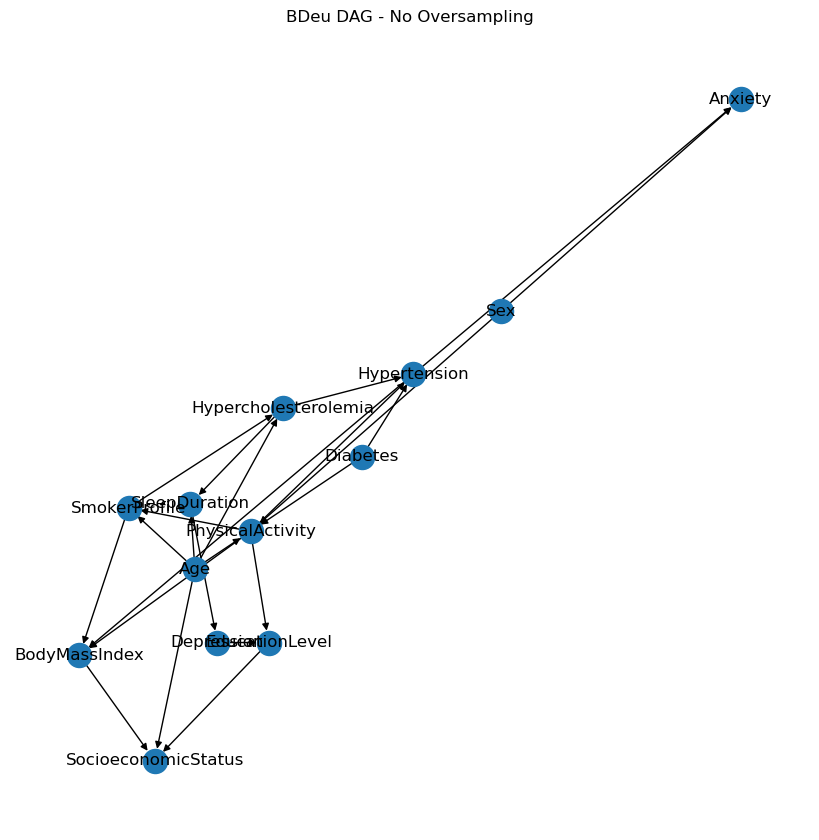

In [24]:
# Printing the resulting DAG and its edges
plt.figure(figsize=(8, 8))
nx.draw(nx.DiGraph(best_model.edges()), with_labels=True)
plt.title('BDeu DAG - No Oversampling')
plt.draw()
print(best_model.edges())

#### 2.2. Paramether Learning - Using the DAG to get the Conditional Probability Distributions (CPDs)

In the next cells, we will be using the DAG structure to estimate the CPDs from the data, defining the probability of a node considering its parents. 

In order to fit the model to our training data we will be using the K2 prior type, since we have a solid understanding of the relationships between some variables but want to avoid assumptions about the exact parameter values, so as to avoid excessive reliance on a limited dataset.

In [30]:
# Setting the bayesian network to use the nodes obtained from the DAG
bm = BayesianNetwork()
bm.add_nodes_from(nodes)
bm.add_edges_from(best_model.edges)

In [ ]:
# We chose to keep our assumptions limited to the root nodes and therefore chose the pseudo_counts = 1
bm.fit(df_train, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=1)

/home/valentxi/miniconda3/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/valentxi/miniconda3/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/valentxi/miniconda3/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

In [ ]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

# printing all conditional probability distributions (CPDs) from our data.
for c in bm.get_cpds():
    print_full(c)


+---------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+-----------------------------------------+------------------------------------+
| Age                       | Age(18-24)                              | Age(18-24)                         | Age(24-34)                              | Age(24-34)                         | Age(34-44)                              | Age(34-44)                         | Age(44-54)                              | Age(44-54)                         | Age(54-64)                              | Age(54-64)                         | Age(64-74)                              | Age(64-74)                   

## 3. Network and Problem Analysis

In the next few cells we will be using the Network to analyse some relationships between our variables, drawing conclusions about how their relate. We will be using variable elimination so as to simplify the problem and instead of calculating all the variables altogether and managing potential dependencies, we will focus only on the variables of interest to the question at hand.

In [33]:
infer = VariableElimination(bm)

##### a. How age affects sleep duration

In [34]:
# Analysis on the probability of the sleep duration knowing the age of the individual

for Age in df_train['Age'].unique():
    print(Age)
    print(infer.query(['SleepDuration'], evidence={'Age': Age}))

54-64
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8300 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1667 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0033 |
+-------------------------+----------------------+
24-34
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.9365 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.0590 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0045 |
+-------------------------+----------------------+
34-44
+-------------------------+----------------------+
| SleepDurati

Given this data we can observe is that there is a tendency for elderly people to have shorter sleep duration. This isn't something linear as the eldest group is also the one with the highest probability of having the longest sleep time. This phenomenom could be justified given the lower sample size of the eldest group, but an argument could be made that the youngest group has a similar ammount of samples and stays in concordance with the ones with higher sample volume.

One detail that could be particulatly relevant would be the way sleep duration is being measured.  With such board intervals its natural that most people would fall in the 6-9h category. More interesting results could have been achieved if the data had slightly shorter sleep intervals, such as -5h, 6-7, 8-9, 9+. A 3 hours sleep interval is something average working/non-retired people could natually fluctuate on their weekly/monthly routine.

##### b. How does the smoker profile affect the three medical conditions (diabetes,hypertension and hypercholesterolemia)

In [36]:
# Checking The Prob of Diabetes Given the Smoker Profile
for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Diabetes')
    print(infer.query(['Diabetes'], evidence={'SmokerProfile': Profile}))

# Checking The Prob of Hypercholesterolemia Given the Smoker Profile
for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer.query(['Hypercholesterolemia'], evidence={'SmokerProfile': Profile}))

# Checking The Prob of Hypertension Given the Smoker Profile
for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Hypertension')
    print(infer.query(['Hypertension'], evidence={'SmokerProfile': Profile}))

Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9507 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0493 |
+---------------+-----------------+
Non_Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9543 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0457 |
+---------------+-----------------+
Ex_Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9585 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0415 |
+---------------+-----------------+
Smoker Hypercholesterolemia
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+============

The data shows no evidence of the smoking profile affecting **diabetes**. 

Non-Smoker are at lower risk of **hypercholesterolemia**, although ex-smokers are as likely to develop hypercholesterolemia as current smokers. 

Smokers have the highest risk of developing **hypertension**, although the data shows that giving up smoking will reduce the risk; unsurprisingly, non-smokers have the lowest hypertension risk.  

##### c. How body mass index affects the three medical conditions

In [38]:
# Checking the Prob of Diabetes given the BMI
for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Diabetes')
    print(infer.query(['Diabetes'], evidence={'BodyMassIndex': Profile}))

# Checking the Prob of Hypercholesterolemia given the BMI
for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer.query(['Hypercholesterolemia'], evidence={'BodyMassIndex': Profile}))

# Checking the Prob of Hypertension given the BMI
for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Hypertension')
    print(infer.query(['Hypertension'], evidence={'BodyMassIndex': Profile}))

Overweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9539 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0461 |
+---------------+-----------------+
Obese Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9568 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0432 |
+---------------+-----------------+
Normal Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9519 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0481 |
+---------------+-----------------+
Underweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9562 |
+---------------+-----------

The data shows no evidence of body mass index having an effect on **diabetes**. 

Data suggest that by being underweight you are more likely to have cholesterol. Since the sample size for underweight patients is the most limited, the observed relationship between underweight status and high cholesterol may not be statistically robust. It is possible that both being underweight and having **hypercholesterolemia** are related to other factors, like poor diet or lack of exercise.

The data also point to being more prone to develop hypertension if one is either obese or underweight. Obesity is a known risk factor for hypertension, leading to insulin resistance, inflammation, and hormonal imbalances, which can contribute to elevated blood pressure levels. On the other hand, individuals who are underweight may experience malnutrition or an underlying medical condition that affects blood pressure regulation.


##### d. How education level affects depression

In [ ]:
# prob of having depression given the education level
for Level in df_train['EducationLevel'].unique():
    print(Level)
    print(infer.query(['Depression'], evidence={'EducationLevel': Level}))

2
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9936 |
+-----------------+-------------------+
| Depression(Yes) |            0.0064 |
+-----------------+-------------------+
3
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9951 |
+-----------------+-------------------+
| Depression(Yes) |            0.0049 |
+-----------------+-------------------+
1
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.7547 |
+-----------------+-------------------+
| Depression(Yes) |            0.2453 |
+-----------------+-------------------+


The data suggests that education level and depression are inversely correlated. However, there is a very small sample of individuals with education level 1. 

However, it would be plausible to consider that people with lower education would have lower income and higher job instability. This situation could lead to financial strain which is a known risk factor for depression.

## 4. Evaluating Medical Conditions

When it comes to predicting medical conditions, its important to recognize that `accuracy` alone may not be the most relevant metric for evaluating model quality.
Although more `accuracy` is desirable. Given the nature of our data, the presence of *false positives* is preferable to *false negatives*, as it is best to falsely identify a medical condition than to overlook one.

With this in mind, we prioritized the `recall` score for 'Yes' predictions to be the most important metric. This doesn't mean we can simply disregard `precision` as if the model were to always predict that the patient is ill, achieving a `recall` of 100%, we wouldn't have gotten any information from the model, rendering it useless, therefore the goal is to achieve a balance between `recall` and `precision`, `[f1-score]`, especially for "Yes" predictions would be the key to get a good, usefull model to identify medical conditions. 

In [45]:
X_test_diabetes = df_test.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

X_train_diabetes = df_train.drop(columns='Diabetes')
y_train_diabetes = df_test['Diabetes']

y_pred = bm.predict(X_test_diabetes)

print(classification_report(y_test_diabetes, y_pred, zero_division=False))
print(confusion_matrix(y_test_diabetes, y_pred))

  0%|          | 0/808 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.95      1.00      0.98      1224
         Yes       0.00      0.00      0.00        58

    accuracy                           0.95      1282
   macro avg       0.48      0.50      0.49      1282
weighted avg       0.91      0.95      0.93      1282

[[1224    0]
 [  58    0]]


From the confusion matrix, we conclude that the model is clearly overfit for predicting Diabetes as it wasn't able to correctly classify not even one instance of diabetes. Due to the extreme class imbalance problem of the diabetes variable, this was already expected.

In [46]:
X_test_hypertension = df_test.drop(columns='Hypertension')
y_test_hypertension = df_test['Hypertension']
y_pred = bm.predict(X_test_hypertension)

print(classification_report(y_test_hypertension, y_pred))
print(confusion_matrix(y_test_hypertension, y_pred))


  0%|          | 0/741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.83      0.98      0.90      1052
         Yes       0.50      0.08      0.14       230

    accuracy                           0.82      1282
   macro avg       0.67      0.53      0.52      1282
weighted avg       0.77      0.82      0.76      1282

[[1033   19]
 [ 211   19]]


Once again we are presented with a similar result. Although we were able to correctly predict some of the Hypertension instances, most of the True instances where classified as Negative.

In [47]:
X_test_cholesterolemia = df_test.drop(columns='Hypercholesterolemia')
y_test_cholesterolemia = df_test['Hypercholesterolemia']
y_pred = bm.predict(X_test_cholesterolemia)
print(classification_report(y_test_cholesterolemia, y_pred))
print(confusion_matrix(y_test_cholesterolemia, y_pred))

  0%|          | 0/704 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.68      0.91      0.78       795
         Yes       0.68      0.30      0.42       487

    accuracy                           0.68      1282
   macro avg       0.68      0.61      0.60      1282
weighted avg       0.68      0.68      0.64      1282

[[727  68]
 [340 147]]


This was the best result between the 3 medical conditions. This improvement is likely due to the sample size and lower imbalance in the training data. 

Although the Accuracy Score is  the lowest out of the 3, these are the most usefull predictions by quite a margin.

## 5. Improving Classification Results

As mentioned before, we have noticed that several variables were quite imbalanced. In this section, we will be looking specifically at diabetes, hypercholesterolemia and hypertension. 

Diabetes, in particular, has the highest imbalance. 

In an attempt to improve our results, we will be using SMOTE - in particular, SMOTENC since it allows for effective handling of both categorical and continuous features. We will be training our Bayesian model to try to predict the three medical conditions.

#### 5.1. Applying SMOTE

##### With SMOTE - Structure Learning

In [ ]:
# using exactly the same method as without SMOTE in section 2.
df_resampled = X_train_resampled
df_resampled['Diabetes'] = y_resampled

In [ ]:
df_resampled.head()

,Age,Anxiety,BodyMassIndex,Depression,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus,Diabetes
0,54-64,No,Overweight,No,2,No,No,Regularly Active,Male,6-9hours,Smoker,3,No
1,24-34,No,Obese,No,3,Yes,No,Regularly Active,Female,6-9hours,Non_Smoker,3,No
2,24-34,No,Overweight,No,2,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1,No
3,34-44,No,Overweight,No,2,Yes,Yes,Regularly Active,Male,<6hours,Non_Smoker,3,No
4,44-54,No,Overweight,No,2,No,Yes,Regularly Active,Female,6-9hours,Smoker,3,Yes


In [ ]:
score_metric = BDeuScore(df_resampled)
es = HillClimbSearch(df_resampled)

In [ ]:
best_eval_balanced = 0
for x, y in zip(range(0,15), rand_list):
    current_balanced_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=y, blacklist=blacklist))
    curr_balanced_eval = score_metric.score(current_balanced_model)
    print(curr_balanced_eval)
    if curr_balanced_eval < best_eval_balanced:
        best_eval_balanced = curr_balanced_eval
        best_balanced_model = current_balanced_model

print(best_eval_balanced)

  0%|          | 0/1000000 [00:00<?, ?it/s]

-40240.10456313599


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40286.87899183345


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40340.896343553475


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40263.60832518365


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40531.05917259469


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40207.411774928456


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40292.11079704359


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40249.960124090874


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40518.34973241224


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40563.627856909014


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40548.28923347405


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40352.19519104511


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40543.18821441103


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40199.731500271926


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40478.321769136855
-40563.627856909014


[('SmokerProfile', 'Diabetes'), ('SmokerProfile', 'PhysicalActivity'), ('SmokerProfile', 'BodyMassIndex'), ('Anxiety', 'SleepDuration'), ('Depression', 'SleepDuration'), ('Depression', 'EducationLevel'), ('Depression', 'Anxiety'), ('Diabetes', 'Hypercholesterolemia'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'EducationLevel'), ('Diabetes', 'Hypertension'), ('Diabetes', 'BodyMassIndex'), ('Diabetes', 'SleepDuration'), ('Diabetes', 'Anxiety'), ('Diabetes', 'Depression'), ('Age', 'Depression'), ('Age', 'SmokerProfile'), ('Age', 'Diabetes'), ('PhysicalActivity', 'Hypertension'), ('Hypertension', 'Hypercholesterolemia'), ('BodyMassIndex', 'Hypertension'), ('BodyMassIndex', 'SocioeconomicStatus'), ('Sex', 'Anxiety'), ('Sex', 'PhysicalActivity'), ('EducationLevel', 'SocioeconomicStatus')]


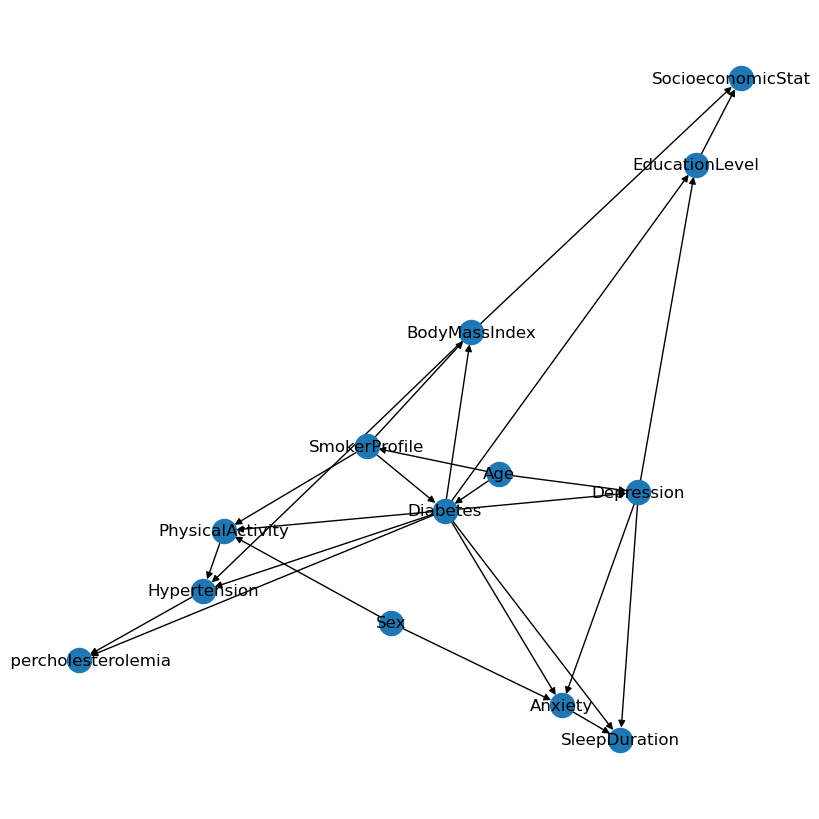

In [ ]:
plt.figure(figsize=(8, 8))
nx.draw(nx.DiGraph(best_balanced_model.edges()), with_labels=True)
plt.draw()
print(best_balanced_model.edges())

##### With SMOTE - Parameter Learning

In [41]:
bm_resampled = BayesianNetwork()
bm_resampled.add_nodes_from(nodes)
bm_resampled.add_edges_from(best_model.edges)

In [42]:
bm_resampled.fit(df_resampled, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=1)

/home/valentxi/miniconda3/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/valentxi/miniconda3/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/valentxi/miniconda3/lib/python3.12/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

In [ ]:
infer_resampled = VariableElimination(bm_resampled) 

for Age in df_resampled['Age'].unique(): 
    print(infer_resampled.query(['SleepDuration'], evidence={'Age': Age}))

+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.7496 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.2039 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0464 |
+-------------------------+----------------------+
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8637 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.0945 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0418 |
+-------------------------+----------------------+
+-------------------------+----------------------+
| SleepDuration           |   p

In [44]:
# Checking the Prob of Diabetes given the BMI
for Profile in df_resampled['BodyMassIndex'].unique():
    print(Profile, 'Diabetes')
    print(infer_resampled.query(['Diabetes'], evidence={'BodyMassIndex': Profile}))

# Checking the Prob of Hypercholesterolemia given the BMI
for Profile in df_resampled['BodyMassIndex'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer_resampled.query(['Hypercholesterolemia'], evidence={'BodyMassIndex': Profile}))

# Checking the Prob of Hypertension given the BMI
for Profile in df_resampled['BodyMassIndex'].unique():
    print(Profile, 'Hypertension')
    print(infer_resampled.query(['Hypertension'], evidence={'BodyMassIndex': Profile}))

Overweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.8433 |
+---------------+-----------------+
| Diabetes(Yes) |          0.1567 |
+---------------+-----------------+
Obese Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.8301 |
+---------------+-----------------+
| Diabetes(Yes) |          0.1699 |
+---------------+-----------------+
Normal Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.8322 |
+---------------+-----------------+
| Diabetes(Yes) |          0.1678 |
+---------------+-----------------+
Underweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.7885 |
+---------------+-----------

#### 5.2. Evaluating The Network

##### With SMOTE

In [48]:
X_test_diabetes = df_test.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

In [49]:
X_resampled_diabetes = df_resampled.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

y_pred = bm_resampled.predict(X_test_diabetes)

print(classification_report(y_test_diabetes, y_pred, zero_division=False))
print(confusion_matrix(y_test_diabetes, y_pred))

  0%|          | 0/808 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.96      0.99      0.97      1224
         Yes       0.28      0.09      0.13        58

    accuracy                           0.95      1282
   macro avg       0.62      0.54      0.55      1282
weighted avg       0.93      0.95      0.94      1282

[[1211   13]
 [  53    5]]


By using SMOTE we can see a slight improvement in the recall score (0.09). This results are not satisfactory and would benefit from other techniques such as undersampling. 

We did not push the balance past the 2:10 scale, since by doing this we are already creating more than double the samples.

In [50]:
X_test_hypertension = df_test.drop(columns='Hypertension')
y_test_hypertension = df_test['Hypertension']
y_pred = bm_resampled.predict(X_test_hypertension)

print(classification_report(y_test_hypertension, y_pred))
print(confusion_matrix(y_test_hypertension, y_pred))


  0%|          | 0/741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.83      0.97      0.90      1052
         Yes       0.43      0.10      0.17       230

    accuracy                           0.81      1282
   macro avg       0.63      0.54      0.53      1282
weighted avg       0.76      0.81      0.76      1282

[[1020   32]
 [ 206   24]]


We can now see a slight increase on the "Yes" recall. We estimate we would get an even higher increase if the oversampling target was hypertension. These are still not satisfying results as the model was only able to correctly predict an extra 5 patients in comparison to the No SMOTE network.

In [51]:
X_test_cholesterolemia = df_test.drop(columns='Hypercholesterolemia')
y_test_cholesterolemia = df_test['Hypercholesterolemia']
y_pred = bm_resampled.predict(X_test_cholesterolemia)
print(classification_report(y_test_cholesterolemia, y_pred))
print(confusion_matrix(y_test_cholesterolemia, y_pred))

  0%|          | 0/704 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.68      0.91      0.78       795
         Yes       0.66      0.29      0.41       487

    accuracy                           0.67      1282
   macro avg       0.67      0.60      0.59      1282
weighted avg       0.67      0.67      0.64      1282

[[721  74]
 [344 143]]


We can see that oversampling did not help at all in predicting the hypercholestromelemia. On the contrary the results where slightly worse then the No SMOTE.

We can hypothetise that samples generated by SMOTE were not accurate, which led to additional noise while attempting to predict hypercholesterolemia. The randomness involved in creating a bayesian network while using the structure obtained with the Hill-Climbing technique is another potential source of inaccuracy as the resampled data could have used a structure with a lower local maxima then the one used in the non-resampled data.

#### Overall Model Performance

Although the resulting structure looks plausible, we are clearly facing overfitting problems with this model. 

Even by applying a SMOTE technique to try and balance the data, it was not enough to considerably improve the results due to the extreme imbalance in the oversampling target.

In our results, we found no additional improvements by using the SMOTE variant (except in diabetes prediction). By not applying SMOTE we can simplify the process, avoiding potential errors originating from reliance on synthetic data.  

The results of the model were not as good as we had hoped. However, this does not diminish our confidence that this approach has the potential to get accurate and useful predictions. We believe that given a higher volume of data containing a more diverse range of samples for each category we would aim to predict, that the model would significantly improve its performance.